# This project use source code from https://github.com/sply88/vcboost/tree/master/vcboost, first need to set path and save (boost.py, loss.py), then import packages

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as ss
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import time

## set self path
import sys
sys.path.append(r'/Desktop')

import boost
import statistics
from scipy.optimize import minimize

from boost import VCBooster
from loss import LS, LAD
%pip install xgboost
import xgboost as xgb
from sklearn.linear_model import HuberRegressor

from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error,mean_squared_error,mean_absolute_error,median_absolute_error,mean_squared_log_error

from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


## Data pre-processing

In [4]:
## file read path
data_all = pd.read_csv(r'/Users/danleizhu/Desktop/simulatedcashflows.csv')

data=data_all[(data_all['AY']==1994)]

## New variables created
data["sum"]=data[["Pay00","Pay01","Pay02","Pay03","Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay00"]+x["Pay01"]+x["Pay02"]+x["Pay03"]+x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year1"]=data[["Pay01","Pay02","Pay03","Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay01"]+x["Pay02"]+x["Pay03"]+x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year2"]=data[["Pay02","Pay03","Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay02"]+x["Pay03"]+x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year3"]=data[["Pay03","Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay03"]+x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year4"]=data[["Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year5"]=data[["Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year6"]=data[["Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year7"]=data[["Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year8"]=data[["Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year9"]=data[["Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data["year10"]=data[["Pay10","Pay11"]].apply(lambda x:x["Pay10"]+x["Pay11"],axis=1)
data["year11"]=data[["Pay11"]].apply(lambda x:x["Pay11"],axis=1)


pay_year = np.array(data[["Pay00","Pay01","Pay02","Pay03","Pay04","Pay05","Pay06",
                          "Pay07","Pay08","Pay09","Pay10","Pay11"]])

data_year = np.array(data[["sum","year1","year2","year3","year4","year5","year6"
                           ,"year7","year8","year9","year10","year11"]])

## Transformation
data[['age']] = np.log(data[['age']])
data[['inj_part']] = np.sqrt(data[['inj_part']])

pay_year = preprocessing.normalize(pay_year)



In [5]:
## Define function to read evaluation metrics of a model

kfold = 5
def metrics(Y_pre,Y_te):
    n = len(Y_te)
    Y_pre = 0.001*Y_pre
    Y_te = 0.001*Y_te
    MSE = mean_squared_error(Y_te,Y_pre)
    MAE = mean_absolute_error(Y_te,Y_pre)
#     MSLE = mean_squared_log_error(Y_te,Y_pre)
    MSLE = (np.sum(np.log((Y_pre+1)/(Y_te+1)))**2)/n
#     R_squared = r2_score(Y_te,Y_pre)
    MAPE =mean_absolute_percentage_error(Y_te,Y_pre)
    MedianAE = median_absolute_error(Y_te,Y_pre)
    return MSE,MAE,MSLE,MAPE,MedianAE

def search_para(model, cv, grid, x, y):
    search = GridSearchCV(model, grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    results = search.fit(x, y)
    print('neg_mean_squared_error: %.4f' % results.best_score_)
    print('Config: %s' % results.best_params_)
    return results.best_params_

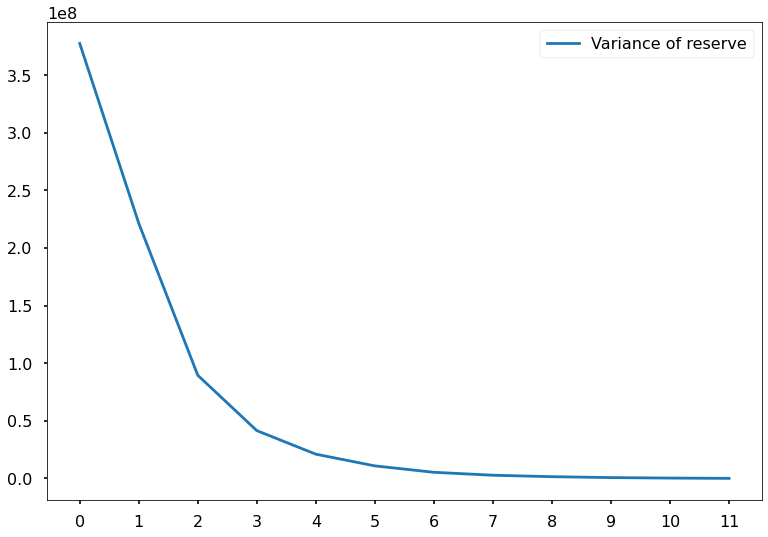

In [291]:
## Analyze the variance of dependent variable for each year

var_ = np.zeros(12)
for i in range(12):
    var_[i] =statistics.variance(data_year[:,i])
name_year = ['0','1','2','3','4','5','6','7','8','9','10','11']
plt.plot(name_year,var_,label = "Variance of reserve")
plt.legend()
plt.show()

## Cross Validation-Linear regression (MLE)

In [18]:
def cvmle(kfold):
    
    lr_grid = list()
    metrics_grid_lr = np.zeros((12,7))
    metrics_grid_lr_ = np.zeros(7)
    for i in range(12):
        X = np.array(data[['LoB','age','inj_part','cc','RepDel','AQ']])

        X = np.column_stack(((pay_year[:,0:i+1]), X))
        X = np.column_stack((np.ones(len(X)), X))
#         print(X.shape)
        nfeatures = X.shape[1]
        Y = data_year[:,i]
        kf = KFold(n_splits=kfold, shuffle = True, random_state = 0)
        MSE = np.zeros(kfold)
        MAE = np.zeros(kfold)
        MSLE = np.zeros(kfold)
        MAPE = np.zeros(kfold)
        MedianAE = np.zeros(kfold)
        runtime_1 = np.zeros(kfold)
        runtime_2 = np.zeros(kfold)
        j = 0
        for train_index , test_index in kf.split(X): 

            N = len(train_index)
            n = len(test_index)
            X_tr = np.zeros((N,nfeatures))
            Y_tr = np.zeros(N)
            X_te = np.zeros((n,nfeatures))
            Y_te = np.zeros(n)
            for r in range(N):
                X_tr[r] = X[train_index[r]]
                Y_tr[r] = Y[train_index[r]]
            for r in range(n):
                X_te[r] = X[test_index[r]]
                Y_te[r] = Y[test_index[r]]
            X_tr = np.column_stack((np.ones(len(X_tr)), X_tr))
            X_te = np.column_stack((np.ones(len(X_te)), X_te))
            
            def linear_regression(x, theta):
                return np.dot(x, theta)

            # Define likelihood function
            def likelihood(theta, x, y):
                y_pred = linear_regression(x, theta)
                residuals = y - y_pred
                n = len(y)
                sigma_sq = np.dot(residuals, residuals) / n
                return -n/2 * np.log(2 * np.pi * sigma_sq) - np.dot(residuals, residuals) / (2 * sigma_sq)

            # Define the objective function to minimize (-1 * likelihood)
            def objective(theta):
                return -likelihood(theta, X_tr, Y_tr)
            n_samples = N
            n_features = X_tr.shape[1]

            theta_0 = np.zeros(n_features)
            start1 = time.time()
            result = minimize(objective, theta_0)
            end1 = time.time()
            runtime1 = end1-start1
            
            start2 = time.time()
            Y_pre = X_te @ result.x
            end2 = time.time()
            runtime2 = end2-start2
            Y_pre = 0.001*Y_pre
            Y_te = 0.001*Y_te
            MSE[j] = mean_squared_error(Y_te,Y_pre)
            MAE[j] = mean_absolute_error(Y_te,Y_pre)
            MSLE[j] = (np.sum(np.log((Y_pre+1)/(Y_te+1)))**2)/n
            MAPE[j] =mean_absolute_percentage_error(Y_te,Y_pre)
            MedianAE[j] = median_absolute_error(Y_te,Y_pre)
            runtime_1[j] = runtime1
            runtime_2[j]= runtime2
            j = j+1
        metrics_grid_lr[i,:] =[MSE.mean().round(6),MAE.mean().round(6),
                               MSLE.mean().round(6),MAPE.mean().round(6),
                               MedianAE.mean().round(6),runtime_1.mean().round(6),
                              runtime_2.mean().round(6)]

    return metrics_grid_lr

X = np.array(data[['LoB','age','inj_part','cc','RepDel','AQ']])
metrics_grid_lr = np.zeros((12,7))
metrics_grid_lr =  cvmle(5)
print(metrics_grid_lr)

[[3.77163693e+02 2.50646100e+00 2.52557807e+03 2.15217523e+15
  1.52262800e+00 1.89177000e-01 3.48000000e-04]
 [2.19992086e+02 1.54005000e+00            nan 2.19151838e+15
  6.70799000e-01 2.04695000e-01 7.30000000e-05]
 [8.76150510e+01 9.23753000e-01            nan 2.06575896e+15
  3.58398000e-01 5.64365000e-01 5.40000000e-05]
 [4.01741050e+01 6.54589000e-01            nan 1.78631116e+15
  2.66571000e-01 1.09560500e+00 5.10000000e-05]
 [2.03142870e+01 4.08180000e-01            nan 1.09166638e+15
  1.26803000e-01 6.84507000e-01 1.07000000e-04]
 [1.03305110e+01 2.82018000e-01            nan 6.96870287e+14
  6.02860000e-02 9.19353000e-01 6.70000000e-05]
 [4.90741400e+00 2.02344000e-01            nan 5.12168228e+14
  5.14010000e-02 6.61451000e-01 8.50000000e-05]
 [2.48346100e+00 1.39563000e-01            nan 3.45415275e+14
  2.88030000e-02 1.39222400e+00 8.90000000e-05]
 [1.37250600e+00 1.10562000e-01            nan 2.98641506e+14
  3.01980000e-02 1.12846400e+00 7.30000000e-05]
 [6.486150

## Cross validation-Varying-coefficients (Decision tree boosted)

In [102]:
def cross_val_vc(X,y,z,kfold,vcb):
    kf = KFold(n_splits=kfold, shuffle = True, random_state = 0)
    j = int(0)
    numfeature = X.shape[1]
    numvc = z.shape[1]
    matrics_record = np.zeros((5,7))
    matrics_mean = np.zeros(7)
    count = 0
    for train_index , test_index in kf.split(X): 
        N = len(train_index)
        n = len(test_index)
        X_tr = np.zeros((N,numfeature))
        y_tr = np.zeros(N)
        z_tr = np.zeros((N,numvc))
        X_te = np.zeros((n,numfeature))
        y_te = np.zeros(n)
        z_te = np.zeros((n,numvc))

        for i in range(N):
            X_tr[i] = X[train_index[i]]
            y_tr[i] = y[train_index[i]]
            z_tr[i] = z[train_index[i]]
        for i in range(n):
            X_te[i] = X[test_index[i]]
            y_te[i] = y[test_index[i]]
            z_te[i] = z[test_index[i]]
        
        start1 = time.time()
        vcb_fit = vcb.fit(X = X_tr, Z = z_tr.reshape(-1,numvc), y = y_tr)
        end1 = time.time()
        runtime1 = end1 - start1
        
        start2 = time.time()
        vcb_pred = vcb.predict(X=X_te, Z=z_te.reshape(-1, numvc))
        end2 = time.time()
        runtime2 = end2 - start2
                
        matrics_record[count,0:-2] = metrics(vcb_pred,y_te)
        matrics_record[count,-2] = runtime1
        matrics_record[count,-1] = runtime2
        count += 1
    for i in range(7):
        matrics_mean[i] = np.mean(matrics_record[:,i])
        
    return matrics_mean

z = np.array(data[['RepDel']])
# z = np.array(data[['inj_part']])

z = z.reshape(-1,1)
kfold = 5
metrics_grid1 = np.zeros((12,7))
numvc = z.shape[1]
for i in range(12):
    X =  np.array(data[['LoB','age','inj_part','cc','RepDel','AQ']])
#     X =  np.array(data[['LoB','age','inj_part','cc','AQ']])

    X = np.column_stack(((pay_year[:,0:i+1]), X))
    X = np.column_stack((np.ones(len(X)), X))
    
    y = data_year[:,i]
    vcb = VCBooster(learning_rate=0.1, min_samples_leaf=1,max_depth = 5, n_stages=1000)
    metrics_grid1[i,:] = cross_val_vc(X,y,z,kfold,vcb)
    
# print(metrics_grid1)


[[3.76862363e+02 2.45258691e+00            nan 1.86869770e+15
  1.44754095e+00 2.59858362e+01 1.07803321e+00]
 [2.19004811e+02 1.51663536e+00            nan 1.55726474e+15
  5.00435418e-01 3.08574214e+01 1.24549880e+00]
 [8.51328775e+01 7.30194564e-01            nan 9.87257278e+14
  1.77437742e-01 3.61001847e+01 1.41629834e+00]
 [3.90406362e+01 4.65584158e-01            nan 7.89693277e+14
  1.02997134e-01 4.24769947e+01 1.58770700e+00]
 [1.96270216e+01 3.20092270e-01            nan 5.86703533e+14
  6.25432842e-02 5.04411652e+01 1.79538832e+00]
 [9.93637462e+00 2.36081452e-01            nan 4.59616109e+14
  4.27830327e-02 4.89381702e+01 1.88157797e+00]
 [4.76967445e+00 1.65638379e-01            nan 3.20778183e+14
  2.59683325e-02 1.19906919e+02 1.99691191e+00]
 [2.42979928e+00 1.17023864e-01            nan 2.35123416e+14
  1.70716528e-02 5.56457367e+01 2.15122223e+00]
 [1.29958874e+00 7.92384087e-02            nan 1.53876688e+14
  1.10059372e-02 5.92660913e+01 2.29508719e+00]
 [6.285152

## Cross validation-Robust (HUBER) linear regression

In [111]:
def cross_val_huber(X,y,kfold,model):
    kf = KFold(n_splits=kfold, shuffle = True, random_state = 0)
    j = int(0)
    numfeature = X.shape[1]
    matrics_record = np.zeros((5,7))
    matrics_mean = np.zeros(7)
    count = 0
    for train_index , test_index in kf.split(X): 
        N = len(train_index)
        n = len(test_index)
        X_tr = np.zeros((N,numfeature))
        y_tr = np.zeros(N)
        X_te = np.zeros((n,numfeature))
        
        y_te = np.zeros(n)

        for i in range(N):
            X_tr[i] = X[train_index[i]]
            y_tr[i] = y[train_index[i]]
        for i in range(n):
            X_te[i] = X[test_index[i]]
            y_te[i] = y[test_index[i]]
            
        X_te = np.column_stack((np.ones(len(X_te)), X))
        start1 = time.time()
        model_fit = model.fit(X_tr,y_tr)
        end1 = time.time()
        runtime1 = end1 - start1
        
        start2 = time.time()
        model_pred = X_te @ model_fit.coef_
        end2 = time.time()
        runtime2 = end2 - start2
        
        matrics_record[count,0:-2] = metrics(model_pred,y_te)
        matrics_record[count,-2] = runtime1
        matrics_record[count,-1] = runtime2 
        count += 1
    for i in range(7):
        matrics_mean[i] = np.mean(matrics_record[:,i])
    return matrics_mean

metrics_grid_huber = np.zeros((12,7))
for i in range(12):
    X = np.array(data[['LoB','age','inj_part','cc','RepDel','AQ']])
    
    X = np.column_stack(((pay_year[:,0:i+1]), X))
#     X = X.values
    y = data_year[:,i]
    N = len(y)
    y = data_year[:,i]
    huber = HuberRegressor()
    metrics_grid_huber[i,:] = cross_val_novc(X,y,kfold,huber)
    


## Decision tree regression (Feature selection)

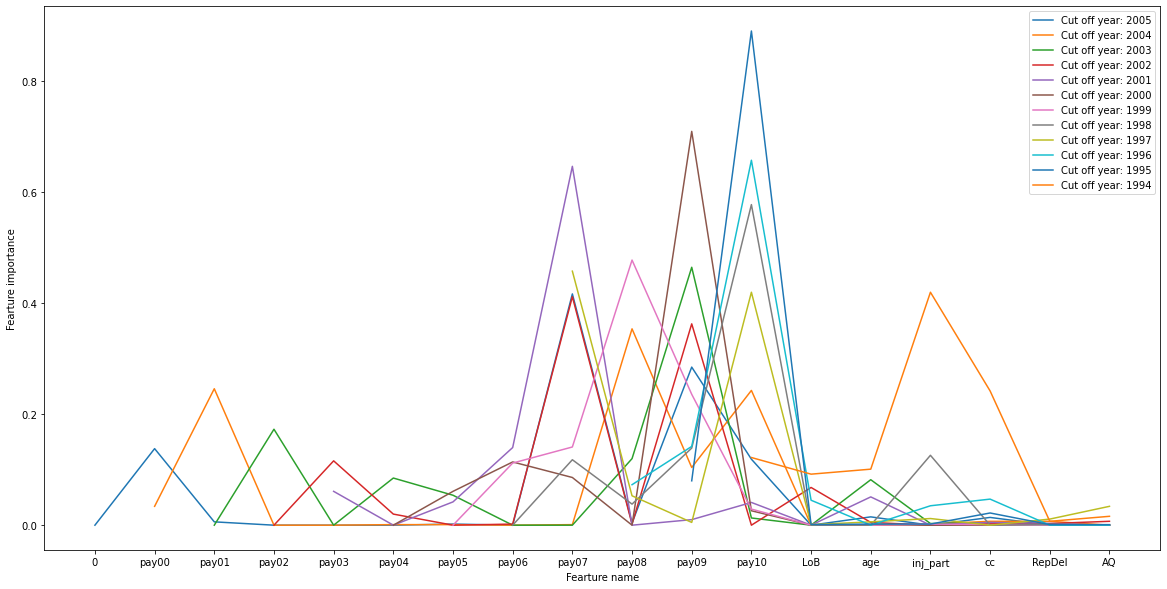

In [92]:
from sklearn import tree

plt.figure(figsize = (20,10))
grid = {'max_depth':[1,2,3,4,5,6,10,20,40,60,80],'min_samples_split':[1,2,4,6,10],
       'max_features':["auto","sqrt","log"],'min_samples_leaf':[1,2,3,4,5,6]}


kfold = 5
cv = 5
dtr_grid = list()
for i in range(11,-1,-1):
    X = np.array(data[['LoB','age','inj_part','cc','RepDel','AQ']])
#     X = np.array(data[['LoB','age','inj_part','RepDel']])
    
    X = np.column_stack(((pay_year[:,0:i+1]), X))
    X = pd.DataFrame(X)
    features = X.columns.tolist()
    features_name = np.array(['Payment_before_year','LoB','age','inj_part','cc','RepDel','AQ'])
    y = data_year[:,i]
#     dtr = tree.DecisionTreeRegressor()
#     para = search_para(dtr, cv, grid, X, y)
    dtr = tree.DecisionTreeRegressor(max_depth = 5, max_features = 'sqrt',
                                    min_samples_leaf = 5,min_samples_split = 5)
    
    dtr_fit = dtr.fit(X, y)
    feature_importance_sk = {}
    importances_sk = dtr_fit.feature_importances_
    for j, feature in enumerate(features):
        feature_importance_sk[feature] = round(importances_sk[j], 3)
    feature_imp = np.zeros(len(feature_importance_sk))
    for j in range(len(feature_importance_sk)):
        feature_imp[j] = feature_importance_sk[j] 
    num_f = np.zeros(X.shape[1])
    for j in range(len(num_f)):
        num_f[j] = int(j+(18-len(num_f)))
    num_fstr = np.array(['0','pay00','pay01','pay02','pay03','pay04','pay05','pay06',
                'pay07','pay08','pay09','pay10','LoB','age','inj_part','cc','RepDel','AQ'])
    st_var = int(num_f[0])
    end_var = int(num_f[-1])+1
    
    plt.plot(num_fstr[st_var:end_var],feature_imp,label = f"Cut off year: {i+1994}")
    
    plt.xticks(num_fstr)
    plt.legend()
    plt.ylabel("Fearture importance")
    plt.xlabel("Fearture name")

plt.show()

## Cross validation-Decision tree regression

In [86]:
from sklearn import tree
import random

def cross_val_novc(X,y,kfold,model):
    kf = KFold(n_splits=kfold, shuffle = True, random_state = 0)
    j = int(0)
    numfeature = X.shape[1]
    matrics_record = np.zeros((5,7))
    matrics_mean = np.zeros(7)
    count = 0
    for train_index , test_index in kf.split(X): 
        N = len(train_index)
        n = len(test_index)
        X_tr = np.zeros((N,numfeature))
        y_tr = np.zeros(N)
        X_te = np.zeros((n,numfeature))
        y_te = np.zeros(n)

        for i in range(N):
            X_tr[i] = X[train_index[i]]
            y_tr[i] = y[train_index[i]]
        for i in range(n):
            X_te[i] = X[test_index[i]]
            y_te[i] = y[test_index[i]]
        start1 = time.time()
        model_fit = model.fit(X_tr,y_tr)
        end1 = time.time()
        runtime1 = end1 - start1
        
        start2 = time.time()
        model_pred = model_fit.predict(X_te)
        end2 = time.time()
        runtime2 = end2 - start2
        
        matrics_record[count,0:-2] = metrics(model_pred,y_te)
        matrics_record[count,-2] = runtime1
        matrics_record[count,-1] = runtime2 
        count += 1
    for i in range(7):
        matrics_mean[i] = np.mean(matrics_record[:,i])
    return matrics_mean



kfold = 5
cv = 5
metrics_grid_dtr = np.zeros((12,7))

for i in range(12):
#     X = np.array(data[['LoB','age','inj_part','cc','RepDel','AQ']])
    X = np.array(data[['LoB','age','inj_part','cc','AQ']])
    X = np.column_stack(((pay_year[:,0:i+1]), X))
    y = data_year[:,i]
    
    dtr = tree.DecisionTreeRegressor(max_depth = 5, max_features = 'sqrt',
                                    min_samples_leaf = 5,min_samples_split = 5,
                                     random_state=99)
    
    metrics_grid_dtr[i,:] = cross_val_novc(X,y,kfold,dtr)
# print(metrics_grid_dtr)



## Training-test evaluation metrics plot

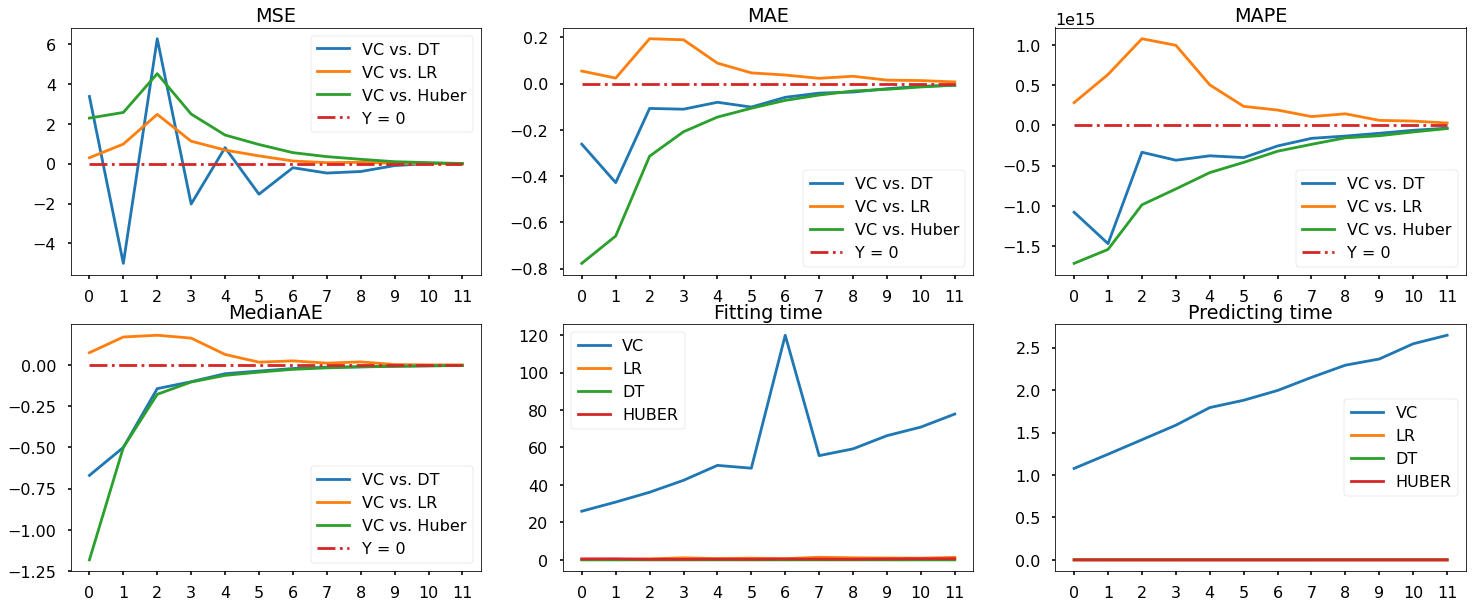

In [433]:
plt.style.use('seaborn-poster')
plt.figure(figsize = (25,10))

name_year = ['0','1','2','3','4','5','6','7','8','9','10','11']
diff1 =metrics_grid_dtr - metrics_grid1
diff2 =metrics_grid_lr - metrics_grid1
diff3 =metrics_grid_huber - metrics_grid1

historical = np.zeros(12)
plt.subplot(2,3,1)
plt.plot(name_year,diff1[:,0],label = "VC vs. DT")
plt.plot(name_year,diff2[:,0],label = "VC vs. LR")
plt.plot(name_year,diff3[:,0],label = "VC vs. Huber")
plt.plot(name_year, historical,"-.",label = "Y = 0")
plt.title("MSE")
plt.legend()

plt.subplot(2,3,2)
plt.plot(name_year,diff1[:,1],label = "VC vs. DT")
plt.plot(name_year,diff2[:,1],label = "VC vs. LR")
plt.plot(name_year,diff3[:,1],label = "VC vs. Huber")

plt.plot(name_year, historical,"-.",label = "Y = 0")
plt.title("MAE")

plt.legend()

plt.subplot(2,3,3)
plt.plot(name_year,diff1[:,3],label = "VC vs. DT")
plt.plot(name_year,diff2[:,3],label = "VC vs. LR")
plt.plot(name_year,diff3[:,3],label = "VC vs. Huber")

plt.plot(name_year, historical,"-.",label = "Y = 0")
plt.legend()
plt.title("MAPE")


plt.subplot(2,3,4)
plt.plot(name_year,diff1[:,4],label = "VC vs. DT")
plt.plot(name_year,diff2[:,4],label = "VC vs. LR")
plt.plot(name_year,diff3[:,4],label = "VC vs. Huber")

plt.plot(name_year, historical,"-.",label = "Y = 0")
plt.title("\nMedianAE")

plt.legend()

plt.subplot(2,3,5)
# plt.plot(name_year,diff1[:,5],label = "VC vs. DT")
# plt.plot(name_year,diff2[:,5],label = "VC vs. LR")
# plt.plot(name_year,diff3[:,5],label = "VC vs. Huber")
plt.plot(name_year,metrics_grid1[:,5],label = "VC")
plt.plot(name_year,metrics_grid_lr[:,5],label = "LR")
plt.plot(name_year,metrics_grid_dtr[:,5],label = "DT")
plt.plot(name_year,metrics_grid_huber[:,5],label = "HUBER")


# plt.plot(name_year, historical,"-.",label = "Y = 0")
plt.title("Fitting time")
plt.legend()

plt.subplot(2,3,6)
plt.plot(name_year,metrics_grid1[:,6],label = "VC")
plt.plot(name_year,metrics_grid_lr[:,6],label = "LR")
plt.plot(name_year,metrics_grid_dtr[:,6],label = "DT")
plt.plot(name_year,metrics_grid_huber[:,6],label = "HUBER")

# plt.plot(name_year, historical,"-.",label = "Y = 0")
plt.title("Predicting time")

plt.legend()
plt.show()

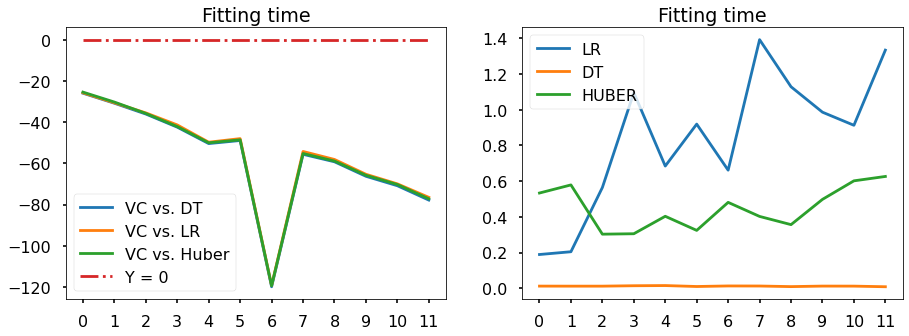

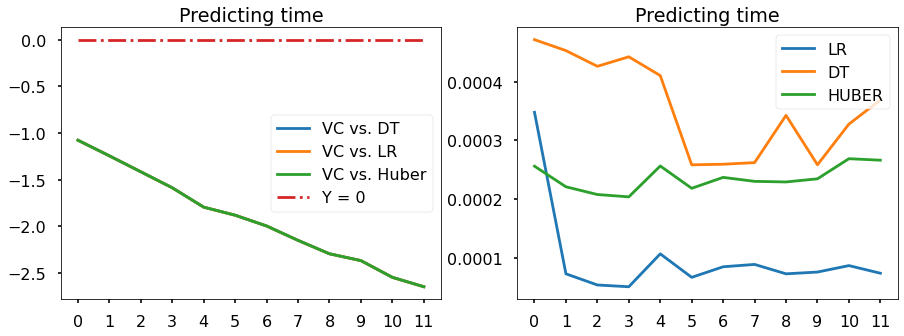

In [431]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(name_year,diff1[:,5],label = "VC vs. DT")
plt.plot(name_year,diff2[:,5],label = "VC vs. LR")
plt.plot(name_year,diff3[:,5],label = "VC vs. Huber")
plt.plot(name_year, historical,"-.",label = "Y = 0")

plt.legend()
plt.title("Fitting time")

plt.subplot(1,2,2)
# plt.plot(name_year,metrics_grid1[:,5],label = "VC")
plt.plot(name_year,metrics_grid_lr[:,5],label = "LR")
plt.plot(name_year,metrics_grid_dtr[:,5],label = "DT")
plt.plot(name_year,metrics_grid_huber[:,5],label = "HUBER")


plt.legend()
plt.title("Fitting time")

plt.show()
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(name_year,diff1[:,6],label = "VC vs. DT")
plt.plot(name_year,diff2[:,6],label = "VC vs. LR")
plt.plot(name_year,diff3[:,6],label = "VC vs. Huber")
plt.plot(name_year, historical,"-.",label = "Y = 0")

plt.legend()
plt.title("Predicting time")

plt.subplot(1,2,2)

# plt.plot(name_year,metrics_grid1[:,6],label = "VC")
plt.plot(name_year,metrics_grid_lr[:,6],label = "LR")
plt.plot(name_year,metrics_grid_dtr[:,6],label = "DT")
plt.plot(name_year,metrics_grid_huber[:,6],label = "HUBER")

plt.title("Predicting time")

plt.legend()
plt.show()

## MLE prediction

In [114]:
def MLE_predict(X,Y):
    X = X
    Y = Y
    def linear_regression(x, theta):
        return np.dot(x, theta)

            # Define likelihood function
    def likelihood(theta, x, y):
        y_pred = linear_regression(x, theta)
        residuals = y - y_pred
        n = len(y)
        sigma_sq = np.dot(residuals, residuals) / n
        return -n/2 * np.log(2 * np.pi * sigma_sq) - np.dot(residuals, residuals) / (2 * sigma_sq)
            # Define the objective function to minimize (-1 * likelihood)
    def objective(theta):
        return -likelihood(theta, X, Y)
    n_samples = N
    n_features = X.shape[1]
    theta_0 = np.zeros(n_features)
        
    result = minimize(objective, theta_0)
    return result.x
    

## Test data pre-processing

In [107]:
data_t=data_all[(data_all['AY']==1995)]

data_t["sum"]=data_t[["Pay00","Pay01","Pay02","Pay03","Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay00"]+x["Pay01"]+x["Pay02"]+x["Pay03"]+x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year1"]=data_t[["Pay01","Pay02","Pay03","Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay01"]+x["Pay02"]+x["Pay03"]+x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year2"]=data_t[["Pay02","Pay03","Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay02"]+x["Pay03"]+x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year3"]=data_t[["Pay03","Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay03"]+x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year4"]=data_t[["Pay04","Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay04"]+x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year5"]=data_t[["Pay05","Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay05"]+x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year6"]=data_t[["Pay06","Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay06"]+x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year7"]=data_t[["Pay07","Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay07"]+x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year8"]=data_t[["Pay08","Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay08"]+x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year9"]=data_t[["Pay09","Pay10","Pay11"]].apply(lambda x:x["Pay09"]+x["Pay10"]+x["Pay11"],axis=1)
data_t["year10"]=data_t[["Pay10","Pay11"]].apply(lambda x:x["Pay10"]+x["Pay11"],axis=1)
data_t["year11"]=data_t[["Pay11"]].apply(lambda x:x["Pay11"],axis=1)

pay_year_t = np.array(data_t[["Pay00","Pay01","Pay02","Pay03","Pay04","Pay05","Pay06",
                          "Pay07","Pay08","Pay09","Pay10","Pay11"]])

data_year_t = np.array(data_t[["sum","year1","year2","year3","year4","year5","year6"
                           ,"year7","year8","year9","year10","year11"]])

data_t[['age']] = np.log(data_t[['age']])
data_t[['inj_part']] = np.sqrt(data_t[['inj_part']])

pay_year_t = preprocessing.normalize(pay_year_t)


## Predictions of reserve for 12 years during policy period, using 4 methods

In [368]:
num_obs = data_t.shape[0]
pred_vc = np.zeros((num_obs,12))
pred_lr = np.zeros((num_obs,12))
pred_dtr = np.zeros((num_obs,12))
pred_rlr = np.zeros((num_obs,12))

for i in range(12):
    X_train = np.array(data[['LoB','age','inj_part','cc','RepDel','AQ']])
    X_train = np.column_stack(((pay_year[:,0:i+1]), X_train))
    X_train_inte = np.column_stack((np.ones(len(X_train)), X_train))
    y_train = data_year[:,i]
    z_train = np.array(data[['RepDel']])
    X_test =  np.array(data_t[['LoB','age','inj_part','cc','RepDel','AQ']])
    X_test = np.column_stack(((pay_year_t[:,0:i+1]), X_test))
    X_test_inte = np.column_stack((np.ones(len(X_test)), X_test))
    y_test = data_year_t[:,i]
    z_test = np.array(data_t[['RepDel']])
    ## VCboost
    numvc = z_train.shape[1]
    vcb_t = VCBooster(learning_rate=0.1, min_samples_leaf=1,max_depth = 5, n_stages=1000)
    vcb_t_fit = vcb_t.fit(X = X_train_inte, Z = z_train.reshape(-1,numvc), y = y_train)
    pred_vc[:,i] = vcb_t_fit.predict(X = X_test_inte,Z = z_test.reshape(-1,numvc))

    X_train_dtr = np.array(data[['LoB','age','inj_part','cc','RepDel','AQ']])
    X_train_dtr = np.column_stack(((pay_year[:,0:i+1]), X_train_dtr))
    X_test_dtr =  np.array(data_t[['LoB','age','inj_part','cc','RepDel','AQ']])
    X_test_dtr = np.column_stack(((pay_year_t[:,0:i+1]), X_test_dtr))
    ## Decision tree
    dtr_t = tree.DecisionTreeRegressor(max_depth = 5, max_features = 'sqrt',
                                    min_samples_leaf = 5,min_samples_split = 5,
                                     random_state=99)
    dtr_t_fit = dtr_t.fit(X_train_dtr, y_train)
    pred_dtr[:,i] = dtr_t_fit.predict(X_test_dtr)
    ## Robust huber regression
    huber_t = HuberRegressor()
    huber_t_fit = huber_t.fit(X_train, y_train)
    pred_rlr[:,i] = X_test @ huber_t_fit.coef_
    # MLE linear regression
    mle_coef = MLE_predict(X_train_inte, y_train)
    pred_lr[:,i] = X_test_inte @ mle_coef 


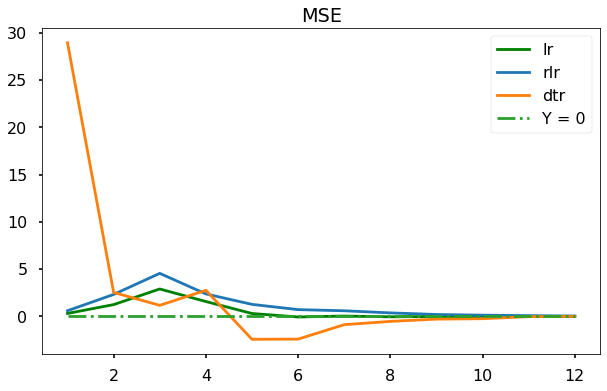

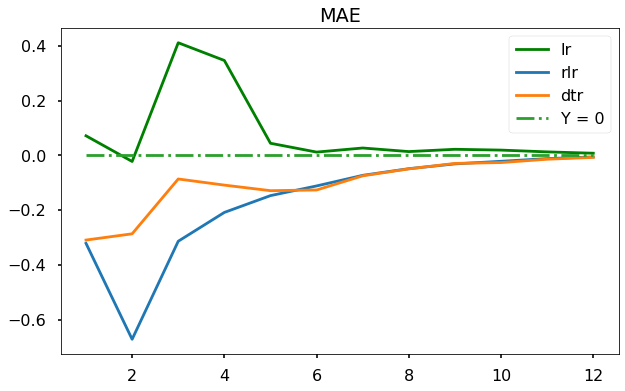

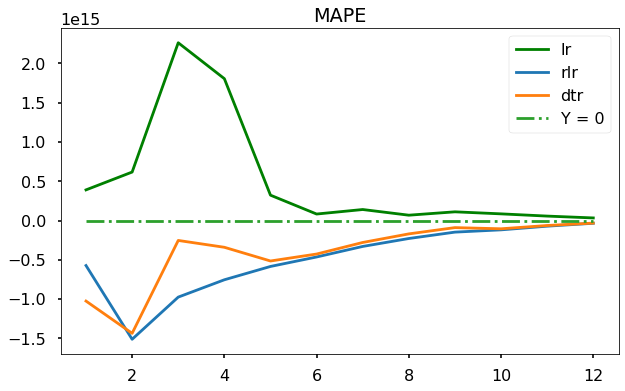

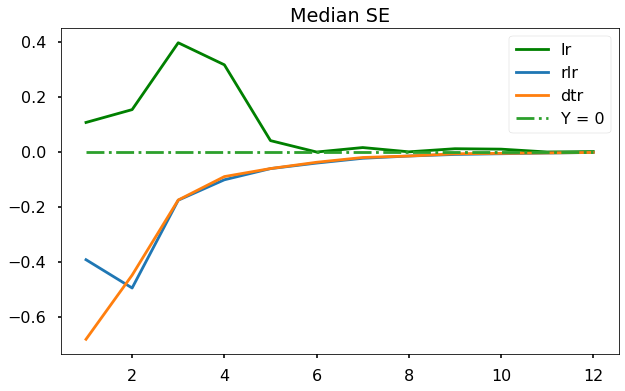

In [432]:
num_obs = data_t.shape[0]
resi_vc = np.zeros((num_obs,12))
resi_lr = np.zeros((num_obs,12))
resi_dtr = np.zeros((num_obs,12))
resi_rlr = np.zeros((num_obs,12))

resi_vc = (data_year_t - pred_vc)
resi_lr =(data_year_t - pred_lr)
resi_dtr = (data_year_t - pred_dtr)
resi_rlr = (data_year_t - pred_rlr)

pred_grid_vc = np.zeros((12,5))
pred_grid_lr = np.zeros((12,5))
pred_grid_rlr = np.zeros((12,5))
pred_grid_dtr = np.zeros((12,5))

for i in range(12):
    pred_grid_vc[i,:] = metrics(pred_vc[:,i],data_year_t[:,i])
    pred_grid_lr[i,:] = metrics(pred_lr[:,i],data_year_t[:,i])
    pred_grid_rlr[i,:] = metrics(pred_rlr[:,i],data_year_t[:,i])
    pred_grid_dtr[i,:] = metrics(pred_dtr[:,i],data_year_t[:,i])
    
diff_t1 = pred_grid_lr - pred_grid_vc
diff_t2 = pred_grid_rlr - pred_grid_vc
diff_t3 = pred_grid_dtr - pred_grid_vc


yearlist = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
pred_grid_vc = np.transpose(pred_grid_vc)
pred_grid_lr = np.transpose(pred_grid_lr)
pred_grid_rlr = np.transpose(pred_grid_rlr)
pred_grid_dtr = np.transpose(pred_grid_dtr)

metrics_name = ['MSE','MAE','MSLE','MAPE','Median SE']
for i in range(5):
    if i!=2:
#         plt.figure(figsize = (15,8))
#         plt.plot(yearlist,pred_grid_vc[i,:],color = "g",label = "VC")
#         plt.plot(yearlist,pred_grid_lr[i,:],label = "LR")
#         plt.plot(yearlist,pred_grid_rlr[i,:],label = "HUBER")
#         plt.plot(yearlist,pred_grid_dtr[i,:],label = "DTR")
#         plt.title(metrics_name[i])
#         plt.legend()
#         plt.show()
        
        plt.figure(figsize = (10,6))
        plt.plot(yearlist,diff_t1[:,i],color = "g",label = "lr")
        plt.plot(yearlist,diff_t2[:,i],label = "rlr")
        plt.plot(yearlist,diff_t3[:,i],label = "dtr")
        plt.plot(yearlist, historical,"-.",label = "Y = 0")
        plt.title(metrics_name[i])
        plt.legend()
        plt.show()
        
    

In [372]:
from tabulate import tabulate
table = list()
true_mean = np.zeros(12)
vcpred_mean= np.zeros(12)
lrpred_mean= np.zeros(12)
dtrpred_mean= np.zeros(12)
rlrpred_mean= np.zeros(12)
table.append(['Year','Real','VCM','LR','DTR','RLR'])
for i in range(12):    
    true_mean[i] = data_year_t[:,i].mean()
    vcpred_mean[i] = pred_vc[:,i].mean()
    lrpred_mean[i] = pred_lr[:,i].mean()
    dtrpred_mean[i] = pred_dtr[:,i].mean()
    rlrpred_mean[i]= pred_rlr[:,i].mean()
    table.append([1995+i,true_mean[i].round(2),vcpred_mean[i].round(2),
                    lrpred_mean[i].round(2),dtrpred_mean[i].round(2),
                    rlrpred_mean[i].round(2)])

table.append(['Sum absolute error','--',np.sum(np.absolute(vcpred_mean-true_mean)).round(2),
                               np.sum(np.absolute(lrpred_mean-true_mean)).round(2),
      np.sum(np.absolute(dtrpred_mean-true_mean)).round(2),
      np.sum(np.absolute(rlrpred_mean-true_mean)).round(2)])
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════════╤═════════╤═════════╤═════════╤═════════╤═════════╕
│ Year               │ Real    │     VCM │      LR │     DTR │     RLR │
╞════════════════════╪═════════╪═════════╪═════════╪═════════╪═════════╡
│ 1995               │ 1788.79 │ 1816.14 │ 1862.73 │ 1781.95 │ 1322.37 │
├────────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1996               │ 894.73  │  908.87 │  919.77 │  865.08 │   91.75 │
├────────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1997               │ 420.77  │  410.86 │  381.99 │  445.21 │    0    │
├────────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1998               │ 254.89  │  251.3  │  239.17 │  257.54 │    0    │
├────────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1999               │ 172.16  │  172.64 │  167.26 │  164.73 │    0    │
├────────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 2000               │ 124.67  │  120.79 │  119.08 

# Coefficients model's performance
## 1. Number of features
## 2. Computational speed
## 6 factors can be selected, 6 choices of feature numbers, fit models on all combinations of each choice, compare mean MSE, MAE, Computational time. This block of code shows the best choice is input 1 feature in coefficient models.
## ( This block may take several days to impletement)

In [434]:
# z = np.array(data[['cc']])

kfold = 5
vcb_grid = list()
metrics_grid1 = np.zeros((12,2))
metrics_grid2 = np.zeros((12,2))
metrics_grid3 = np.zeros((12,2))
metrics_grid4 = np.zeros((12,2))
metrics_grid5 = np.zeros((12,2))
metrics_grid6 = np.zeros((12,2))


for i in range(12):
    X =  np.array(data[['LoB','age','inj_part','cc','RepDel','AQ']])
    factors = np.array(data[['LoB','age','inj_part','cc','RepDel','AQ']])
    num_fac = factors.shape[1]
    X = np.column_stack(((pay_year[:,0:i+1]), X))
    y = data_year[:,i]
    vcb = VCBooster(learning_rate=0.01, min_samples_leaf=0.05,max_depth = 5, n_stages=800)

    for j in range(1,num_fac+1):
        if j==1:
            
            mse1,mae1 = 0,0
            count1 = 0
            for a in range(num_fac):
                z = np.array(factors[:,a])
                numvc = j
                z = z.reshape(-1,j)
                X_tr,y_tr,z_tr,X_te,y_te,z_te = cross_val(X,y,z,kfold)
                vcb.fit(X = X_tr, Z = z_tr.reshape(-1,numvc), y = y_tr)
                vcb_pred = vcb.predict(X=X_te, Z=z_te.reshape(-1, numvc))
#                 vcb_grid.append(vcb_pred)
                mse1_,mae1_ = metrics(vcb_pred,y_te)
                mse1 += mse1_
                mae1 += mae1_
                count1 = count1 + 1
                
            metrics_grid1[i,0] = mse1/count1
            metrics_grid1[i,1] = mae1/count1
            
        if j==2:
            mse2,mae2 = 0,0
            count2 = 0
            for a in range(num_fac):
                for b in range(a+1,num_fac):
                    z = factors[:,(a,b)]
                    numvc = j
                    X_tr,y_tr,z_tr,X_te,y_te,z_te = cross_val(X,y,z,kfold)
                    vcb.fit(X = X_tr, Z = z_tr.reshape(-1,numvc), y = y_tr)
                    vcb_pred = vcb.predict(X=X_te, Z=z_te.reshape(-1, numvc))
#                     vcb_grid.append(vcb_pred)
                    mse2_,mae2_ = metrics(vcb_pred,y_te)
                    mse2 += mse2_
                    mae2 += mae2_
                    count2 = count2 + 1
            metrics_grid2[i,0] = mse2/count2
            metrics_grid2[i,1] = mae2/count2
            
        if j==3:
            mse3,mae3 = 0,0
            count3 = 0
            for a in range(num_fac):
                for b in range(a+1,num_fac):
                    for c in range(b+1,num_fac):
                        z = factors[:,(a,b,c)]
                        numvc = j
                        X_tr,y_tr,z_tr,X_te,y_te,z_te = cross_val(X,y,z,kfold)
                        
                        vcb.fit(X = X_tr, Z = z_tr.reshape(-1,numvc), y = y_tr)
                        vcb_pred = vcb.predict(X=X_te, Z=z_te.reshape(-1, numvc))
#                         vcb_grid.append(vcb_pred)
                        metrics_grid3[i,:] = metrics(vcb_pred,y_te)
                        mse3_,mae3_ = metrics(vcb_pred,y_te)
                        mse3 += mse3_
                        mae3 += mae3_
                        count3 = count3 + 1
            metrics_grid3[i,0] = mse3/count3
            metrics_grid3[i,1] = mae3/count3
        if j==4:
            mse4,mae4 = 0,0
            count4 = 0
            for a in range(num_fac):
                for b in range(a+1,num_fac):
                    for c in range(b+1,num_fac):
                        for d in range(c+1,num_fac):
                            z = factors[:,(a,b,c,d)]
                            numvc = j
                            X_tr,y_tr,z_tr,X_te,y_te,z_te = cross_val(X,y,z,kfold)
                            vcb.fit(X = X_tr, Z = z_tr.reshape(-1,numvc), y = y_tr)
                            vcb_pred = vcb.predict(X=X_te, Z=z_te.reshape(-1, numvc))
#                             vcb_grid.append(vcb_pred)
                            metrics_grid4[i,:] = metrics(vcb_pred,y_te)
                            mse4_,mae4_ = metrics(vcb_pred,y_te)
                            mse4 += mse4_
                            mae4 += mae4_
                            count4 = count4 + 1
            metrics_grid4[i,0] = mse4/count4
            metrics_grid4[i,1] = mae4/count4
        if j==5:
            mse5,mae5 = 0,0
            count5 = 0
            for a in range(num_fac):
                for b in range(a+1,num_fac):
                    for c in range(b+1,num_fac):
                        for d in range(c+1,num_fac):
                            for e in range(d+1,num_fac):
                                z = factors[:,(a,b,c,d,e)]
                                numvc = j
                                X_tr,y_tr,z_tr,X_te,y_te,z_te = cross_val(X,y,z,kfold)
                                vcb.fit(X = X_tr, Z = z_tr.reshape(-1,numvc), y = y_tr)
                                vcb_pred = vcb.predict(X=X_te, Z=z_te.reshape(-1, numvc))
#                                 vcb_grid.append(vcb_pred)
                                metrics_grid5[i,:] = metrics(vcb_pred,y_te)
                                mse5_,mae5_ = metrics(vcb_pred,y_te)
                                mse5 += mse5_
                                mae5 += mae5_
                                count5 = count5 + 1
            metrics_grid5[i,0] = mse5/count5
            metrics_grid5[i,1] = mae5/count5
        else:
            z = factors
            numvc = 6
            X_tr,y_tr,z_tr,X_te,y_te,z_te = cross_val(X,y,z,kfold)
            vcb.fit(X = X_tr, Z = z_tr.reshape(-1,numvc), y = y_tr)
            vcb_pred = vcb.predict(X=X_te, Z=z_te.reshape(-1, numvc))
            metrics_grid6[i,:] = metrics(vcb_pred,y_te)
                            

NameError: name 'cross_val' is not defined